In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import sys
from os.path import join as pjoin

# from gpsa import VariationalGPSA
from gpsa import matern12_kernel, rbf_kernel
from gpsa.plotting import callback_twod, callback_twod_multimodal

# from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import r2_score

import scanpy as sc
import anndata
import os

torch.manual_seed(10)
np.random.seed(10)

In [2]:
import torch.nn as nn
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

# Define model
class GPSA(nn.Module):
    """
    Args:
        data_dict (dict): Dictionary of data in the format {"modality": {"spatial_coords": X, "outputs": Y, "n_samples_list": n_samples_list}}
        data_init (bool, optional): Whether to initialize inducing locations with KMeans on data.
        n_spatial_dims (int, optional): Number of spatial dimensions (usually 2 or 3).
        n_noise_variance_params (int, optional): Number of noise variance parameters.
        kernel_func_warp (function, optional): Covariance function for warp GP.
        kernel_func_data (function, optional): Covariance function for output GP.
        mean_function (str, optional): Mean function for warp GP. One of ["identity_fixed", "identity_initialized", or None]. None results in a linear mean function.
        mean_penalty_param (float, optional): Description
        fixed_warp_kernel_variances (None, optional): Description
        fixed_warp_kernel_lengthscales (None, optional): Description
        fixed_data_kernel_lengthscales (None, optional): Description
    """

    def __init__(
        self,
        data_dict,
        data_init=True,
        n_spatial_dims=2,
        n_noise_variance_params=2,
        kernel_func_warp=rbf_kernel,
        kernel_func_data=rbf_kernel,
        mean_function="identity_fixed",
        mean_penalty_param=0.0,
        fixed_warp_kernel_variances=None,
        fixed_warp_kernel_lengthscales=None,
        fixed_data_kernel_lengthscales=None,
    ):
        # Constructor
        super(GPSA, self).__init__()
        self.modality_names = list(data_dict.keys())
        self.n_modalities = len(self.modality_names)
        self.mean_penalty_param = mean_penalty_param

        ## Make sure all modalities have the same number of "views"
        n_views = np.unique(
            np.array(
                [len(data_dict[mod]["n_samples_list"]) for mod in self.modality_names]
            )
        )
        if len(n_views) != 1:
            raise ValueError("Each modality must have the same number of views.")
        self.n_views = n_views[0]

        ## Make sure all modalities have the same domain for the spatial coordinates
        n_spatial_dims = np.unique(
            np.array(
                [
                    data_dict[mod]["spatial_coords"].shape[1]
                    for mod in self.modality_names
                ]
            )
        )
        if len(n_spatial_dims) != 1:
            raise ValueError(
                "Each modality must have the same number of spatial dimensions."
            )
        self.n_spatial_dims = n_spatial_dims[0]

        view_idx, Ns, Ps, n_total = self.create_view_idx_dict(data_dict)
        self.view_idx = view_idx
        self.Ns = Ns
        self.Ps = Ps
        self.n_total = n_total
        # import ipdb; ipdb.set_trace()

        ## Number of kernel parameters:
        ##		- 2 parameters for each view for warp GP (lengthscale and variance)
        ##		- 2 parameters for observation GP (lengthscale and variance)
        self.n_kernel_params = 2 * self.n_views + 2
        self.n_noise_variance_params = n_noise_variance_params
        self.kernel_func_warp = kernel_func_warp
        self.kernel_func_data = kernel_func_data

        ## Parameters
        self.noise_variance = nn.Parameter(
            torch.randn([self.n_noise_variance_params]) - 1
        )
        # self.noise_variance = torch.log(torch.ones(2) * 0.001)

        if fixed_warp_kernel_variances is None:
            # self.warp_kernel_variances = nn.Parameter(
            #     torch.randn([self.n_kernel_params // 2 - 1]) - 1
            # )
            self.warp_kernel_variances = nn.Parameter(
                torch.zeros(self.n_kernel_params // 2 - 1)
            )
        else:
            self.warp_kernel_variances = torch.log(
                torch.tensor(fixed_warp_kernel_variances)
            )

        if fixed_warp_kernel_lengthscales is None:
            # self.warp_kernel_lengthscales = nn.Parameter(
            #     torch.randn([self.n_kernel_params // 2 - 1]) + 3
            # )
            self.warp_kernel_lengthscales = nn.Parameter(
                torch.zeros(self.n_kernel_params // 2 - 1) + np.log(10)
            )
        else:
            self.warp_kernel_lengthscales = torch.log(
                torch.tensor(fixed_warp_kernel_lengthscales)
            )

        if fixed_data_kernel_lengthscales is None:
            self.data_kernel_lengthscale = nn.Parameter(
                torch.log(torch.exp(torch.randn(1)))
            )
        else:
            self.data_kernel_lengthscale = torch.log(
                torch.tensor(fixed_data_kernel_lengthscales).float()
            )

        self.data_kernel_variance = nn.Parameter(torch.randn(1))
        # self.data_kernel_variance = nn.Parameter(torch.zeros(1))
        # self.data_kernel_variance = torch.tensor(0.).float()

        if mean_function == "identity_fixed":
            self.mean_slopes = (
                torch.eye(self.n_spatial_dims, device=device)
                .unsqueeze(0)
                .repeat(self.n_views, 1, 1)
            )
            self.mean_intercepts = torch.zeros(
                [self.n_views, self.n_spatial_dims], device=device
            )
        elif mean_function == "identity_initialized":
            self.mean_slopes = nn.Parameter(
                torch.randn([self.n_views, self.n_spatial_dims, self.n_spatial_dims])
            )
            self.mean_intercepts = nn.Parameter(
                torch.zeros([self.n_views, self.n_spatial_dims])
            )
        else:
            self.mean_slopes = nn.Parameter(
                torch.eye(self.n_spatial_dims).unsqueeze(0).repeat(self.n_views, 1, 1)
            )
            self.mean_intercepts = nn.Parameter(
                torch.randn([self.n_views, self.n_spatial_dims]) * 0.1
            )

        # self.mean_intercepts = torch.zeros([self.n_views, self.n_spatial_dims])
        self.diagonal_offset = 1e-5

    def create_view_idx_dict(self, data_dict):
        """Summary

        Args:
            data_dict (TYPE): Description

        Returns:
            TYPE: Description
        """
        view_idx, Ns, Ps = {}, {}, {}
        n_total = 0
        for mod in self.modality_names:
            n_samples_list = data_dict[mod]["n_samples_list"]
            # self.n_samples_lists[mod] = n_samples_list
            curr_N = np.sum(n_samples_list)
            Ns[mod] = curr_N
            n_total += curr_N
            Ps[mod] = data_dict[mod]["outputs"].shape[1]

            # Compute the indices of each view for each modality
            cumulative_sums = np.cumsum(n_samples_list)
            cumulative_sums = np.insert(cumulative_sums, 0, 0)
            curr_view_idx = [
                np.arange(cumulative_sums[ii], cumulative_sums[ii + 1])
                for ii in range(self.n_views)
            ]
            view_idx[mod] = curr_view_idx

        return view_idx, Ns, Ps, n_total

    def compute_mean_penalty(self):
        return self.mean_penalty_param * torch.mean(
            torch.square(
                self.mean_slopes
                - torch.eye(self.n_spatial_dims).unsqueeze(0).repeat(self.n_views, 1, 1)
            )
        )

    def forward(self, X_spatial):
        raise (NotImplementedError)

    def loss_fn(self, data_dict, Gs, means_G_list, covs_G_list, means_Y, covs_Y):
        raise (NotImplementedError)


def distance_matrix(X, Y):
    """Compute distances between samples (rows) of two matrices

    Args:
        X (array): n x D matrix of spatial locations
        Y (array): m x D matrix of spatial locations

    Returns:
        array: n x m matrix whose ij'th elementh is the Euclidean distance between i'th row of X and j'th row of Y
    """
    squared_diffs = torch.square(torch.unsqueeze(X, 0) - torch.unsqueeze(Y, 1))
    squared_distances = torch.sum(squared_diffs, dim=2)
    return squared_distances


if __name__ == "__main__":

    pass

In [3]:
from sklearn.cluster import KMeans
from collections.abc import Iterable

torch.autograd.set_detect_anomaly(True)

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

class VariationalGPSA(GPSA):
    def __init__(
        self,
        data_dict,
        m_X_per_view,
        m_G,
        data_init=True,
        minmax_init=False,
        grid_init=False,
        n_spatial_dims=2,
        n_noise_variance_params=2,
        kernel_func_warp=rbf_kernel,
        kernel_func_data=rbf_kernel,
        n_latent_gps=None,
        mean_function="identity_fixed",
        mean_penalty_param=0.0,
        fixed_warp_kernel_variances=None,
        fixed_warp_kernel_lengthscales=None,
        fixed_data_kernel_lengthscales=None,
        fixed_view_idx=None,
    ):
        super(VariationalGPSA, self).__init__(
            data_dict,
            data_init=True,
            n_spatial_dims=2,
            n_noise_variance_params=2,
            kernel_func_warp=kernel_func_warp,
            kernel_func_data=kernel_func_data,
            mean_penalty_param=mean_penalty_param,
            fixed_warp_kernel_variances=fixed_warp_kernel_variances,
            fixed_warp_kernel_lengthscales=fixed_warp_kernel_lengthscales,
            fixed_data_kernel_lengthscales=fixed_data_kernel_lengthscales,
        )

        self.m_X_per_view = m_X_per_view
        self.m_G = m_G
        self.n_latent_gps = n_latent_gps
        self.n_latent_outputs = {}
        for mod in self.modality_names:
            curr_n_latent_outputs = (
                self.n_latent_gps[mod]
                if self.n_latent_gps[mod] is not None
                else self.Ps[mod]
            )
            self.n_latent_outputs[mod] = curr_n_latent_outputs
        self.fixed_view_idx = fixed_view_idx

        if data_init:
            # Initialize inducing locations with a subset of the data
            Xtilde = torch.zeros([self.n_views, self.m_X_per_view, self.n_spatial_dims])
            for ii in range(self.n_views):
                curr_X_spatial_list = []
                for mod in self.modality_names:
                    curr_idx = self.view_idx[mod][ii]
                    curr_modality_and_view_spatial = data_dict[mod]["spatial_coords"][
                        curr_idx, :
                    ]
                    curr_X_spatial_list.append(curr_modality_and_view_spatial)
                curr_X_spatial = torch.cat(curr_X_spatial_list, dim=0)

                kmeans = KMeans(n_clusters=self.m_X_per_view, random_state=10)
                kmeans.fit(curr_X_spatial.detach().cpu().numpy())
                Xtilde[ii, :, :] = torch.tensor(kmeans.cluster_centers_)

            self.Xtilde = nn.Parameter(Xtilde.clone())
            # self.Xtilde = Xtilde.clone()

            rand_idx = np.random.choice(
                np.arange(curr_X_spatial.shape[0]),
                size=self.m_G,
                replace=False,
            )

            all_X_spatial = torch.cat(
                [data_dict[mod]["spatial_coords"] for mod in self.modality_names]
            )
            kmeans = KMeans(n_clusters=self.m_G, random_state=10)
            kmeans.fit(all_X_spatial.detach().cpu().numpy())
            self.Gtilde = nn.Parameter(torch.tensor(kmeans.cluster_centers_))

        elif grid_init:

            if self.n_spatial_dims == 2:
                xlow, ylow = (
                    data_dict[self.modality_names[0]]["spatial_coords"].numpy().min(0)
                )
                xhigh, yhigh = (
                    data_dict[self.modality_names[0]]["spatial_coords"].numpy().max(0)
                )
                xlimits = [xlow, xhigh]
                ylimits = [ylow, yhigh]
                numticks = np.ceil(np.sqrt(self.m_G)).astype(int)
                self.m_G = numticks**2
                self.m_X_per_view = numticks**2
                x1s = np.linspace(*xlimits, num=numticks)
                x2s = np.linspace(*ylimits, num=numticks)
                X1, X2 = np.meshgrid(x1s, x2s)
                Xtilde = np.vstack([X1.ravel(), X2.ravel()]).T
                Xtilde_torch = torch.zeros(
                    [self.n_views, Xtilde.shape[0], self.n_spatial_dims]
                )
                for vv in range(self.n_views):
                    Xtilde_torch[vv] = torch.tensor(Xtilde)

                # self.Xtilde = Xtilde_torch.clone()
                # self.Gtilde = torch.tensor(Xtilde).float()
                self.Xtilde = nn.Parameter(Xtilde_torch.clone())
                self.Gtilde = nn.Parameter(torch.tensor(Xtilde).float())

        else:
            # Random initialization of inducing locations
            self.Xtilde = nn.Parameter(
                torch.randn([self.n_views, self.m_X_per_view, self.n_spatial_dims])
            )
            self.Gtilde = nn.Parameter(torch.randn([self.m_G, self.n_spatial_dims]))

        ## Variational covariance parameters
        Omega_sqt_G_list = torch.zeros(
            [self.n_views * self.n_spatial_dims, self.m_X_per_view, self.m_X_per_view],
            device=device,
        )
        for ii in range(self.n_views):
            for jj in range(self.n_spatial_dims):
                Omega_sqt = 0.1 * torch.randn(
                    size=[self.m_X_per_view, self.m_X_per_view]
                )
                # import ipdb; ipdb.set_trace()
                # Omega_sqt_G_list[ii * self.n_views + jj, :, :] = Omega_sqt
                Omega_sqt_G_list[jj * self.n_views + ii, :, :] = Omega_sqt
        self.Omega_sqt_G_list = nn.Parameter(Omega_sqt_G_list)

        Omega_sqt_F_dict = torch.nn.ParameterDict()
        for mod in self.modality_names:
            num_outputs = self.Ps[mod]
            curr_Omega = torch.zeros([self.n_latent_outputs[mod], self.m_G, self.m_G])
            for jj in range(self.n_latent_outputs[mod]):
                Omega_sqt = 0.1 * torch.randn(size=[self.m_G, self.m_G])
                curr_Omega[jj, :, :] = Omega_sqt
            Omega_sqt_F_dict[mod] = nn.Parameter(curr_Omega)
        self.Omega_sqt_F_dict = Omega_sqt_F_dict

        ## Variational mean parameters
        self.delta_G_list = nn.Parameter(self.Xtilde.clone())
        delta_F_dict = torch.nn.ParameterDict()
        for mod in self.modality_names:
            num_outputs = self.Ps[mod]
            curr_delta = nn.Parameter(
                torch.randn(size=[self.m_G, self.n_latent_outputs[mod]], device=device)
            )
            delta_F_dict[mod] = curr_delta
        self.delta_F_dict = delta_F_dict

        ## LMC parameters
        self.W_dict = torch.nn.ParameterDict()
        for mod in self.modality_names:
            if self.n_latent_gps[mod] is not None:
                self.W_dict[mod] = nn.Parameter(
                    torch.randn([self.n_latent_gps[mod], self.Ps[mod]])
                )

    def compute_mean_and_var(
        self, Kff_diag, Kuf, Kuu_chol, mu_x, mu_z, delta, Omega_tril
    ):
        alpha_x = torch.cholesky_solve(Kuf, Kuu_chol)

        a_t_Kchol = torch.matmul(alpha_x.transpose(-1, -2), Kuu_chol)
        aKa = torch.sum(torch.square(a_t_Kchol), dim=-1)

        mu_tilde = mu_x.unsqueeze(0) + torch.matmul(
            alpha_x.transpose(-1, -2), delta - mu_z
        )

        if len(alpha_x.shape) == 2:
            a_t_Omega_tril = torch.matmul(
                alpha_x.transpose(-1, -2).unsqueeze(0), Omega_tril
            )
            aOmega_a = torch.sum(torch.square(a_t_Omega_tril), dim=-1)
            Sigma_tilde = Kff_diag - aKa + aOmega_a + self.diagonal_offset
        else:
            a_t_Omega_tril = torch.matmul(
                alpha_x.transpose(-1, -2).unsqueeze(1), Omega_tril.unsqueeze(0)
            )
            aOmega_a = torch.sum(torch.square(a_t_Omega_tril), dim=-1)
            Sigma_tilde = (
                Kff_diag.unsqueeze(1)
                - aKa.unsqueeze(1)
                + aOmega_a
                + self.diagonal_offset
            )

        return mu_tilde, Sigma_tilde + self.diagonal_offset

    def get_Omega_from_Omega_sqt(self, Omega_sqt):
        return torch.matmul(
            Omega_sqt,
            torch.transpose(Omega_sqt, -1, -2),
        ) + self.diagonal_offset * torch.eye(Omega_sqt.shape[-1], device=device)

    def forward(self, X_spatial, view_idx, Ns, S=1, prediction_mode=False, G_test=None):

        if prediction_mode:
            self.eval()

        self.noise_variance_pos = torch.exp(self.noise_variance) + self.diagonal_offset

        self.mu_z_G = (
            torch.zeros(
                [self.n_views, self.m_X_per_view, self.n_spatial_dims], device=device
            )
            * np.nan
        )
        for vv in range(self.n_views):
            self.mu_z_G[vv] = (
                torch.mm(self.Xtilde[vv], self.mean_slopes[vv])
                + self.mean_intercepts[vv]
            )
            if self.fixed_view_idx is not None and (
                vv in self.fixed_view_idx
                if isinstance(self.fixed_view_idx, Iterable)
                else self.fixed_view_idx == vv
            ):
                self.mu_z_G[vv] *= 100.0

        self.Kuu_chol_list = (
            torch.zeros(
                [self.n_views, self.m_X_per_view, self.m_X_per_view], device=device
            )
            * np.nan
        )
        G_samples = {}
        for mod in self.modality_names:
            G_samples[mod] = (
                torch.zeros([S, Ns[mod], self.n_spatial_dims], device=device) * np.nan
            )

        G_means = {}
        for mod in self.modality_names:
            G_means[mod] = (
                torch.zeros([Ns[mod], self.n_spatial_dims], device=device) * np.nan
            )

        curr_Omega_G = self.get_Omega_from_Omega_sqt(self.Omega_sqt_G_list)

        self.curr_Omega_tril_list = torch.cholesky(curr_Omega_G)

        for vv in range(self.n_views):

            ## If this view is fixed (template-based alignment), then we don't need to sample for it.
            if self.fixed_view_idx is not None and (
                vv in self.fixed_view_idx
                if isinstance(self.fixed_view_idx, Iterable)
                else self.fixed_view_idx == vv
            ):
                for mm, mod in enumerate(self.modality_names):
                    observed_X_spatial = X_spatial[mod][view_idx[mod][vv]]
                    G_means[mod][view_idx[mod][vv]] = observed_X_spatial

                    G_samples[mod][:, view_idx[mod][vv], :] = observed_X_spatial

                continue

            kernel_G = lambda x1, x2, diag=False: self.kernel_func_warp(
                x1,
                x2,
                lengthscale_unconstrained=self.warp_kernel_lengthscales[vv],
                output_variance_unconstrained=self.warp_kernel_variances[vv],
                diag=diag,
            )

            ## Collect data from all modalities for this view
            curr_X_spatial_list = []
            curr_n = 0
            curr_mod_idx = []
            for mod in self.modality_names:
                curr_idx = view_idx[mod][vv]
                curr_mod_idx.append(np.arange(curr_n, curr_n + len(curr_idx)))
                curr_n += len(curr_idx)
                curr_modality_and_view_spatial = X_spatial[mod][curr_idx, :]
                curr_X_spatial_list.append(curr_modality_and_view_spatial)

            curr_X_spatial = torch.cat(curr_X_spatial_list, dim=0)

            if len(curr_X_spatial) == 0:
                continue

            curr_X_tilde = self.Xtilde[vv]

            mu_x_G = (
                torch.mm(curr_X_spatial, self.mean_slopes[vv])
                + self.mean_intercepts[vv]
            )

            # Kff_diag = (
            #     kernel_G(curr_X_spatial, curr_X_spatial, diag=True)
            #     + self.diagonal_offset
            # )
            Kff_diag = torch.ones((curr_X_spatial.shape[0]), device=device) * torch.exp(
                self.warp_kernel_variances[vv]
            )

            Kuu = kernel_G(
                curr_X_tilde, curr_X_tilde
            ) + self.diagonal_offset * torch.eye(self.m_X_per_view, device=device)

            Kuf = kernel_G(curr_X_tilde, curr_X_spatial)

            Kuu_chol = torch.cholesky(Kuu)
            self.Kuu_chol_list[vv, :, :] = Kuu_chol

            mu_tilde, Sigma_tilde = self.compute_mean_and_var(
                Kff_diag,
                Kuf,
                Kuu_chol,
                mu_x_G,
                self.mu_z_G,
                self.delta_G_list,
                self.curr_Omega_tril_list,
            )

            # Sample
            G_marginal_dist = torch.distributions.Normal(
                mu_tilde[vv],
                Sigma_tilde[
                    vv * self.n_spatial_dims : vv * self.n_spatial_dims
                    + self.n_spatial_dims
                ].t(),
            )

            for mm, mod in enumerate(self.modality_names):
                curr_idx = curr_mod_idx[mm]
                G_means[mod][view_idx[mod][vv]] = mu_tilde[vv][curr_idx]

            for ss in range(S):

                curr_G_sample = G_marginal_dist.rsample()
                for mm, mod in enumerate(self.modality_names):
                    curr_idx = curr_mod_idx[mm]
                    G_samples[mod][ss, view_idx[mod][vv]] = curr_G_sample[curr_idx]

        self.curr_Omega_tril_F = {}
        for mod in self.modality_names:
            self.curr_Omega_tril_F[mod] = torch.zeros(
                [self.n_latent_outputs[mod], self.m_G, self.m_G], device=device
            )

        F_samples = {}
        self.F_latent_samples = {}
        self.F_observed_samples = {}
        for mod in self.modality_names:
            F_samples[mod] = torch.zeros([S, Ns[mod], self.n_latent_outputs[mod]])
            self.F_latent_samples[mod] = torch.zeros(
                [S, Ns[mod], self.n_latent_outputs[mod]], device=device
            )
            self.F_observed_samples[mod] = torch.zeros([S, Ns[mod], self.Ps[mod]])

        if G_test is not None:

            self.F_latent_samples_test = {}
            self.F_observed_samples_test = {}
            for mod in self.modality_names:
                n_test = G_test[mod].shape[1]
                self.F_latent_samples_test[mod] = torch.zeros(
                    [S, n_test, self.n_latent_outputs[mod]]
                )
                self.F_observed_samples_test[mod] = torch.zeros(
                    [S, n_test, self.Ps[mod]]
                )

        kernel_F = lambda x1, x2, diag=False: self.kernel_func_data(
            x1,
            x2,
            lengthscale_unconstrained=self.data_kernel_lengthscale,
            output_variance_unconstrained=self.data_kernel_variance,
            diag=diag,
        )

        Kuu = kernel_F(self.Gtilde, self.Gtilde) + self.diagonal_offset * torch.eye(
            self.m_G, device=device
        )

        self.Kuu_chol_F = torch.cholesky(Kuu)

        for mod in self.modality_names:

            mu_x_F = torch.zeros([Ns[mod], self.n_latent_outputs[mod]], device=device)
            mu_z_F = torch.zeros([self.m_G, self.n_latent_outputs[mod]], device=device)

            # Kff_diag = (
            #     kernel_F(G_samples[mod], G_samples[mod], diag=True)
            #     + self.diagonal_offset
            # )
            Kff_diag = torch.ones(
                (G_samples[mod].shape[:2]), device=device
            ) * torch.exp(self.data_kernel_variance)

            Kuf = kernel_F(self.Gtilde, G_samples[mod])
            curr_Omega = self.get_Omega_from_Omega_sqt(self.Omega_sqt_F_dict[mod])

            self.curr_Omega_tril_F[mod] = torch.cholesky(curr_Omega)
            mu_tilde, Sigma_tilde = self.compute_mean_and_var(
                Kff_diag,
                Kuf,
                self.Kuu_chol_F,
                mu_x_F,
                mu_z_F,
                self.delta_F_dict[mod],
                self.curr_Omega_tril_F[mod],
            )

            eps = torch.randn(mu_tilde.shape, device=device)
            curr_F_latent_samples = (
                mu_tilde + torch.sqrt(torch.transpose(Sigma_tilde, 1, 2)) * eps
            )

            if self.n_latent_gps[mod] is not None:
                curr_W = self.W_dict[mod]
                F_observed_mean = torch.matmul(curr_F_latent_samples, curr_W)
            else:
                F_observed_mean = curr_F_latent_samples

            self.F_latent_samples[mod] = curr_F_latent_samples
            self.F_observed_samples[mod] = F_observed_mean

            ## For test samples
            if G_test is not None:
                # Kff_diag = (
                #     kernel_F(G_samples[mod], G_samples[mod], diag=True)
                #     + self.diagonal_offset
                # )
                Kff_diag = torch.ones(
                    (G_test[mod].shape[:2]), device=device
                ) * torch.exp(
                    self.data_kernel_variance,
                )

                mu_x_F = torch.zeros(
                    [G_test[mod].shape[1], self.n_latent_outputs[mod]], device=device
                )

                Kuf = kernel_F(self.Gtilde, G_test[mod])

                mu_tilde, Sigma_tilde = self.compute_mean_and_var(
                    Kff_diag,
                    Kuf,
                    self.Kuu_chol_F,
                    mu_x_F,
                    mu_z_F,
                    self.delta_F_dict[mod],
                    self.curr_Omega_tril_F[mod],
                )

                eps = torch.randn(mu_tilde.shape, device=device)
                curr_F_latent_samples = (
                    mu_tilde + torch.sqrt(torch.transpose(Sigma_tilde, 1, 2)) * eps
                )

                if self.n_latent_gps[mod] is not None:
                    curr_W = self.W_dict[mod]
                    F_observed_mean = torch.matmul(curr_F_latent_samples, curr_W)
                else:
                    F_observed_mean = curr_F_latent_samples

                self.F_latent_samples_test[mod] = curr_F_latent_samples
                self.F_observed_samples_test[mod] = F_observed_mean

        if G_test is not None:
            return (
                G_means,
                G_samples,
                self.F_latent_samples,
                self.F_observed_samples,
                self.F_latent_samples_test,
                self.F_observed_samples_test,
            )
        else:
            return G_means, G_samples, self.F_latent_samples, self.F_observed_samples

    def loss_fn(self, data_dict, F_samples):
        # This computes the the negative (approximate) ELBO

        # Running sum for KL terms
        KL_div = 0

        ## G
        for vv in range(self.n_views):
            if self.fixed_view_idx is not None and (
                vv in self.fixed_view_idx
                if isinstance(self.fixed_view_idx, Iterable)
                else self.fixed_view_idx == vv
            ):
                continue
            for jj in range(self.n_spatial_dims):
                qu = torch.distributions.MultivariateNormal(
                    loc=self.delta_G_list[vv, :, jj],
                    scale_tril=self.curr_Omega_tril_list[jj * self.n_views + vv, :, :],
                )
                pu = torch.distributions.MultivariateNormal(
                    loc=self.mu_z_G[vv, :, jj],
                    scale_tril=self.Kuu_chol_list[vv, :, :],
                )
                curr_KL_div = torch.distributions.kl.kl_divergence(qu, pu)

                KL_div += curr_KL_div

        ## F
        LL = 0
        pu = torch.distributions.MultivariateNormal(
            loc=torch.zeros(self.m_G, device=device), scale_tril=self.Kuu_chol_F
        )
        for mm, mod in enumerate(self.modality_names):
            qu = torch.distributions.MultivariateNormal(
                loc=self.delta_F_dict[mod].t(),
                scale_tril=self.curr_Omega_tril_F[mod],
            )

            curr_KL_div = torch.distributions.kl.kl_divergence(qu, pu)
            KL_div += curr_KL_div.sum()

            Y_distribution = torch.distributions.Normal(
                loc=F_samples[mod],
                scale=self.noise_variance_pos[-self.n_modalities + mm],
            )
            S = F_samples[mod].shape[0]

            LL += Y_distribution.log_prob(data_dict[mod]["outputs"]).sum() / S

        return -LL + KL_div


if __name__ == "__main__":
    pass

In [4]:
def find_matching_indices(list1, list2):
    """
    Finds indices of matching elements between two lists of possibly different lengths and returns a 2D NumPy array.

    :param list1: The first list.
    :param list2: The second list.
    :return: A 2D NumPy array where each row contains the indices of matching elements (index_list1, index_list2).
    """
    # Determine which list is shorter
    if len(list1) <= len(list2):
        shorter, longer = list1, list2
        primary_index_is_list1 = True
    else:
        shorter, longer = list2, list1
        primary_index_is_list1 = False

    # Using a list to store matching index pairs
    matching_indices = []

    # Iterate over the shorter list to find matches in the longer list
    for idx_short, value in enumerate(shorter):
        try:
            idx_long = longer.index(value)  # Find the first occurrence in the longer list
            if primary_index_is_list1:
                matching_indices.append([idx_short, idx_long])
            else:
                matching_indices.append([idx_long, idx_short])
        except ValueError:
            continue  # Continue if the value is not found in the longer list

    # Convert the list of indices to a 2D NumPy array
    return np.array(matching_indices, dtype=int)

In [5]:
def mse_coordinates(coords1, coords2):
    """
    Calculate the Mean Squared Error (MSE) between two sets of coordinates.

    :param coords1: A numpy array of shape (n, 2) containing the first set of coordinates.
    :param coords2: A numpy array of shape (n, 2) containing the second set of coordinates.
    :return: The MSE as a single float.
    """
    if coords1.shape != coords2.shape:
        raise ValueError("Both coordinate arrays must have the same shape.")

    # Calculate the squared differences and their mean
    mse = np.mean((coords1 - coords2) ** 2)
    return mse

In [6]:
def scale_spatial_coords(X, max_val=10.0):
    X = X - X.min(0)
    X = X / X.max(0)
    return X * max_val


def process_data(adata, n_top_genes=2000):
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

    # sc.pp.filter_cells(adata, min_counts=5000)    
    sc.pp.filter_cells(adata, min_counts=100)
    sc.pp.filter_cells(adata, max_counts=35000)
    # adata = adata[adata.obs["pct_counts_mt"] < 20]
    sc.pp.filter_genes(adata, min_cells=10)

    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(
        adata, flavor="seurat", n_top_genes=n_top_genes, subset=True
    )
    return adata


def process_image(adata):

    img_keys = [*adata.uns["spatial"]]
    assert len(img_keys) == 1
    curr_key = img_keys[0]
    img = adata.uns["spatial"][curr_key]["images"]["hires"]
    scale_factor = adata.uns["spatial"][curr_key]["scalefactors"]["tissue_hires_scalef"]
    adata.obsm["spatial"] = adata.obsm["spatial"] * scale_factor

    img_size = img.shape

    x1_img, x2_img = np.meshgrid(
        np.arange(img_size[1]),
        np.arange(img_size[0]),
    )
    X_img = np.vstack([x1_img.ravel(), x2_img.ravel()]).T * 1.0

    pixel_vals = np.array(
        [
            img[X_img[ii, 1].astype(int), X_img[ii, 0].astype(int)]
            for ii in range(X_img.shape[0])
        ]
    )

    nongray_idx = np.where(~np.all(np.round(pixel_vals, 1) == GRAY_PIXEL_VAL, axis=1))[
        0
    ]
    pixel_vals = pixel_vals[nongray_idx, :]
    X_img = X_img[nongray_idx, :]
    X_img_original = X_img.copy()
    pixel_vals_original = pixel_vals.copy()

    ## Remove image pixels outside of expression region
    xmax, ymax = adata.obsm["spatial"].max(0)
    xmin, ymin = adata.obsm["spatial"].min(0)
    inside_idx = np.where(
        (X_img[:, 0] > xmin)
        & (X_img[:, 0] < xmax)
        & (X_img[:, 1] > ymin)
        & (X_img[:, 1] < ymax)
    )[0]
    X_img = X_img[inside_idx]
    pixel_vals = pixel_vals[inside_idx]

    adata.uns["img_spatial"] = X_img
    adata.uns["img_pixels"] = pixel_vals

    return adata

In [8]:
def get_library_id(adata):
    assert 'spatial' in adata.uns, "spatial not present in adata.uns"
    library_ids = adata.uns['spatial'].keys()
    try:
        library_id = list(library_ids)[0]
        return library_id
    except IndexError:
        logger.error('No library_id found in adata')

def get_scalefactors(adata, library_id=None):
    if library_id is None:
        library_id = get_library_id(adata)
    try:
        scalef = adata.uns['spatial'][library_id]['scalefactors']
        return scalef
    except IndexError:
        logger.error('scalefactors not found in adata')

def get_spot_diameter_in_pixels(adata, library_id=None):
    scalef = get_scalefactors(adata, library_id=library_id) 
    try:
        spot_diameter = scalef['spot_diameter_fullres']
        return spot_diameter    
    except TypeError:
        pass
    except KeyError:
        logger.error('spot_diameter_fullres not found in adata')

# Simulation

In [9]:
all_simu_dir = '/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/'

## Read data

In [10]:
raw_data_name = '10X_Visium_Barkley2022Cancer_GSM6177599_NYU_BRCA0_Vis_processed_data'

In [11]:
simu_dataset_dir = all_simu_dir+raw_data_name+'/'

In [12]:
DATA_DIR = simu_dataset_dir
SCALEFACTOR = 0.17211704
GRAY_PIXEL_VAL = 0.7
N_GENES = 10

N_SAMPLES = 8000

n_spatial_dims = 2
n_views = 2

m_G = 200
m_X_per_view = 200

# N_EPOCHS = 6000
N_EPOCHS = 2000
PRINT_EVERY = 100
N_LATENT_GPS = {"expression": None, "histology": None}

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [13]:
tar_sample_name = 'adata_simulation_raw.h5ad'
ad_tar = sc.read_h5ad(os.path.join(simu_dataset_dir, tar_sample_name))

In [14]:
library_id = get_library_id(ad_tar)
scalef = ad_tar.uns['spatial'][library_id]['scalefactors']['tissue_hires_scalef']

In [21]:
data_slice1 = sc.read_h5ad(pjoin(DATA_DIR, tar_sample_name))
if data_slice1.uns['spatial'][library_id]['images']['hires'].max()>1:
    data_slice1.uns['spatial'][library_id]['images']['hires'] = data_slice1.uns['spatial'][library_id]['images']['hires']/255
data_slice1 = process_data(data_slice1, n_top_genes=6000)
data_slice1 = process_image(data_slice1)

/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


# Align

In [31]:
def gpsa_aligment(data_slice1, src_sample_name):
    data_slice2 = sc.read_h5ad(simu_dataset_dir+src_sample_name)
    if data_slice2.uns['spatial'][library_id]['images']['hires'].max()>1:
        data_slice2.uns['spatial'][library_id]['images']['hires'] = data_slice2.uns['spatial'][library_id]['images']['hires']/255
    data_slice2 = process_data(data_slice2, n_top_genes=6000)
    data_slice2 = process_image(data_slice2)
    
    data = data_slice1.concatenate(data_slice2)
    
    ## Filter for spatially variable genes
    shared_gene_names = data.var.gene_ids.index.values
    data_knn = data_slice1[:, shared_gene_names]
    X_knn = data_knn.obsm["spatial"]
    Y_knn = np.array(data_knn.X.todense())
    nbrs = NearestNeighbors(n_neighbors=2).fit(X_knn)
    distances, indices = nbrs.kneighbors(X_knn)
    
    preds = Y_knn[indices[:, 1]]
    r2_vals = r2_score(Y_knn, preds, multioutput="raw_values")
    
    gene_idx_to_keep = np.where(r2_vals > 0.3)[0]
    N_GENES_new = min(N_GENES, len(gene_idx_to_keep))
    gene_names_to_keep = data_knn.var.gene_ids.index.values[gene_idx_to_keep]
    gene_names_to_keep = gene_names_to_keep[np.argsort(-r2_vals[gene_idx_to_keep])]
    if N_GENES_new < len(gene_names_to_keep):
        gene_names_to_keep = gene_names_to_keep[:N_GENES_new]
    data = data[:, gene_names_to_keep]
    
    ## Filter number of samples
    if N_SAMPLES is not None:
    
        if N_SAMPLES < data_slice1.shape[0]:
            rand_idx = np.random.choice(
                np.arange(data_slice1.shape[0]), size=N_SAMPLES, replace=False
            )
            data_slice1 = data_slice1[rand_idx]
    
        if N_SAMPLES < data_slice1.uns["img_spatial"].shape[0]:
            rand_idx = np.random.choice(
                np.arange(data_slice1.uns["img_spatial"].shape[0]),
                size=N_SAMPLES,
                replace=False,
            )
            data_slice1.uns["img_spatial"] = data_slice1.uns["img_spatial"][rand_idx]
            data_slice1.uns["img_pixels"] = data_slice1.uns["img_pixels"][rand_idx]
    
        if N_SAMPLES < data_slice2.shape[0]:
            rand_idx = np.random.choice(
                np.arange(data_slice2.shape[0]), size=N_SAMPLES, replace=False
            )
            data_slice2 = data_slice2[rand_idx]
    
        if N_SAMPLES < data_slice2.uns["img_spatial"].shape[0]:
            rand_idx = np.random.choice(
                np.arange(data_slice2.uns["img_spatial"].shape[0]),
                size=N_SAMPLES,
                replace=False,
            )
            data_slice2.uns["img_spatial"] = data_slice2.uns["img_spatial"][rand_idx]
            data_slice2.uns["img_pixels"] = data_slice2.uns["img_pixels"][rand_idx]
    
    data = data_slice1.concatenate(data_slice2)
    data = data[:, gene_names_to_keep]
    n_samples_list_expression = [data_slice1.shape[0], data_slice2.shape[0]]
    n_samples_list_histology = [
        data_slice1.uns["img_spatial"].shape[0],
        data_slice2.uns["img_spatial"].shape[0],
    ]
    view_idx = [
        np.arange(data_slice1.shape[0]),
        np.arange(data_slice1.shape[0], data_slice1.shape[0] + data_slice2.shape[0]),
    ]
    
    ### Expression
    X1_expression = data[data.obs.batch == "0"].obsm["spatial"]
    X2_expression = data[data.obs.batch == "1"].obsm["spatial"]
    Y1_expression = np.array(data[data.obs.batch == "0"].X.todense())
    Y2_expression = np.array(data[data.obs.batch == "1"].X.todense())
    
    X1_expression = scale_spatial_coords(X1_expression)
    X2_expression = scale_spatial_coords(X2_expression)
    
    Y1_expression = (Y1_expression - Y1_expression.mean(0)) / Y1_expression.std(0)
    Y2_expression = (Y2_expression - Y2_expression.mean(0)) / Y2_expression.std(0)
    
    X_expression = np.concatenate([X1_expression, X2_expression])
    Y_expression = np.concatenate([Y1_expression, Y2_expression])
    
    ### Histology
    X1_histology = data_slice1.uns["img_spatial"]
    X2_histology = data_slice2.uns["img_spatial"]
    Y1_histology = data_slice1.uns["img_pixels"]
    Y2_histology = data_slice2.uns["img_pixels"]
    
    X1_histology = scale_spatial_coords(X1_histology)
    X2_histology = scale_spatial_coords(X2_histology)
    
    Y1_histology_rgb = Y1_histology.copy()
    Y2_histology_rgb = Y2_histology.copy()
    
    
    Y1_histology_mean = Y1_histology.mean(0)
    Y1_histology_stddev = Y1_histology.std(0)
    Y2_histology_mean = Y2_histology.mean(0)
    Y2_histology_stddev = Y2_histology.std(0)
    
    Y1_histology = (Y1_histology - Y1_histology_mean) / Y1_histology_stddev
    Y2_histology = (Y2_histology - Y2_histology_mean) / Y2_histology_stddev
    
    X_histology = np.concatenate([X1_histology, X2_histology])
    Y_histology = np.concatenate([Y1_histology, Y2_histology])
    Y_histology_rgb = np.concatenate([Y1_histology_rgb, Y2_histology_rgb])
    
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "cpu"
    
    x_expression = torch.from_numpy(X_expression).float().clone()
    x_histology = torch.from_numpy(X_histology).float().clone()
    y_expression = torch.from_numpy(Y_expression).float().clone()
    y_histology = torch.from_numpy(Y_histology).float().clone()
    y_histology_rgb = torch.from_numpy(Y_histology_rgb).float().clone()
    
    data_dict = {
        "expression": {
            "spatial_coords": x_expression,
            "outputs": y_expression,
            "n_samples_list": n_samples_list_expression,
        },
        "histology": {
            "spatial_coords": x_histology,
            "outputs": y_histology,
            "n_samples_list": n_samples_list_histology,
        },
    }
    
    
    data_dict_rgb = {
        "expression": {
            "spatial_coords": x_expression,
            "outputs": y_expression,
            "n_samples_list": n_samples_list_expression,
        },
        "histology": {
            "spatial_coords": x_histology,
            "outputs": y_histology_rgb,
            "n_samples_list": n_samples_list_histology,
        },
    }
    
    model = VariationalGPSA(
        data_dict,
        n_spatial_dims=n_spatial_dims,
        m_X_per_view=m_X_per_view,
        m_G=m_G,
        data_init=True,
        minmax_init=False,
        grid_init=False,
        n_latent_gps=N_LATENT_GPS,
        mean_function="identity_fixed",
        # fixed_warp_kernel_variances=np.ones(n_views) * 0.1,
        # fixed_warp_kernel_lengthscales=np.ones(n_views) * 10,
        n_noise_variance_params=3,
        fixed_view_idx=0,
    ).to(device)
    
    view_idx, Ns, _, _ = model.create_view_idx_dict(data_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    
    def train(model, loss_fn, optimizer):
        model.train()
    
        # Forward pass
        G_means, G_samples, F_latent_samples, F_samples = model.forward(
            X_spatial={"expression": x_expression, "histology": x_histology},
            view_idx=view_idx,
            Ns=Ns,
        )
    
        # Compute loss
        loss = loss_fn(data_dict, F_samples)
    
        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        return loss.item(), G_means
    
    
    # Set up figure.
    fig = plt.figure(figsize=(7, 7), facecolor="white", constrained_layout=True)
    
    data_expression_ax = fig.add_subplot(221, frameon=False)
    data_histology_ax = fig.add_subplot(222, frameon=False)
    latent_expression_ax = fig.add_subplot(223, frameon=False)
    latent_histology_ax = fig.add_subplot(224, frameon=False)
    axes_list = [
        data_expression_ax,
        data_histology_ax,
        latent_expression_ax,
        latent_histology_ax,
    ]
    
    for t in range(N_EPOCHS):
        loss, G_means = train(model, model.loss_fn, optimizer)
    
        if t % PRINT_EVERY == 0:
            print("Iter: {0:<10} LL {1:1.3e}".format(t, -loss), flush=True)
    
            callback_twod_multimodal(
                model=model,
                data_dict=data_dict_rgb,
                axes=axes_list,
                X_aligned=G_means,
                scatterpoint_size=50,
                rgb=True,
            )
    
            curr_aligned_coords_expression = G_means["expression"].detach().numpy()
            curr_aligned_coords_histology = G_means["histology"].detach().numpy()
    
    shared_indices = find_matching_indices(data_slice1.obs.index.tolist(), data_slice2.obs.index.tolist())
    ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
    ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]
    ad_tar_coor = (ad_tar_coor_curr/10)*(data_slice1.obsm['spatial'].max(axis=0)-data_slice1.obsm['spatial'].min(axis=0))+data_slice1.obsm['spatial'].min(axis=0)
    ad_src_coor = (ad_src_coor_curr/10)*(data_slice2.obsm['spatial'].max(axis=0)-data_slice2.obsm['spatial'].min(axis=0))+data_slice2.obsm['spatial'].min(axis=0)
    
    plt.scatter(ad_tar_coor[:,0], ad_tar_coor[:,1],s=3)
    plt.scatter(ad_src_coor[:,0], ad_src_coor[:,1],s=3)
    plt.savefig(result_dir+src_sample_name[:-5]+'.pdf')
    
    distance = np.mean(np.sqrt(np.sum(np.square(ad_tar_coor[shared_indices[:,0]] - ad_src_coor[shared_indices[:,1]]), axis=1)))
    return distance

In [29]:
def batch_aligment(level):
    ad_pertub_name_list = pd.read_csv(simu_dataset_dir+level+'_noisy_simulation_data_names.csv', header=None)
    all_dist = pd.DataFrame()
    
    for src_sample_name in ad_pertub_name_list[0]:
        distance = gpsa_aligment(data_slice1, src_sample_name)
        print(distance)
        all_dist.loc[src_sample_name,'gpsa_distance'] = distance
        all_dist.to_csv(result_dir+level+'_noisy_gpsa_aligned_distance.csv')

In [27]:
result_dir = simu_dataset_dir+'gpsa_results/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

## lowly noisy

In [ ]:
level = 'lowly'

In [ ]:
batch_aligment(level)

## Medium noisy

In [ ]:
level = 'medium'

In [ ]:
batch_aligment(level)

/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2236550/4207273045.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2236550/4207273045.py:61: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  dat

Iter: 0          LL -3.266e+08
Iter: 100        LL -2.325e+06
Iter: 200        LL -4.978e+05
Iter: 300        LL -3.341e+05
Iter: 400        LL -2.713e+05
Iter: 500        LL -2.382e+05
Iter: 600        LL -2.184e+05
Iter: 700        LL -2.061e+05
Iter: 800        LL -1.973e+05
Iter: 900        LL -1.912e+05
Iter: 1000       LL -1.862e+05
Iter: 1100       LL -1.815e+05
Iter: 1200       LL -1.776e+05
Iter: 1300       LL -1.746e+05
Iter: 1400       LL -1.720e+05
Iter: 1500       LL -1.701e+05
Iter: 1600       LL -1.680e+05
Iter: 1700       LL -1.659e+05
Iter: 1800       LL -1.640e+05
Iter: 1900       LL -1.617e+05
CPU times: user 7h 25min 5s, sys: 11min 11s, total: 7h 36min 17s
Wall time: 15min 10s


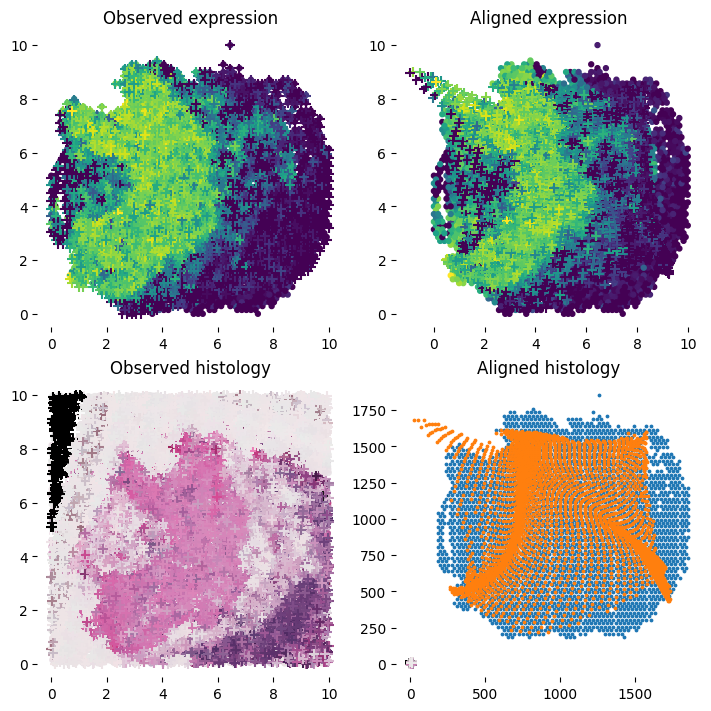

In [76]:
%%time
distance = gpsa_aligment(data_slice1, src_sample_name)

In [81]:
distance

169.91939

## Highly noisy

In [19]:
level = 'highly'

/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2417509/452237377.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2417509/452237377.py:62: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data 

Iter: 0          LL -3.748e+07
Iter: 100        LL -7.555e+04
Iter: 200        LL -6.198e+04
Iter: 300        LL -5.666e+04
Iter: 400        LL -5.348e+04
Iter: 500        LL -5.158e+04
Iter: 600        LL -5.042e+04
Iter: 700        LL -4.973e+04
Iter: 800        LL -4.905e+04
Iter: 900        LL -4.848e+04
Iter: 1000       LL -4.810e+04
Iter: 1100       LL -4.774e+04
Iter: 1200       LL -4.745e+04
Iter: 1300       LL -4.743e+04
Iter: 1400       LL -4.718e+04
Iter: 1500       LL -4.716e+04
Iter: 1600       LL -4.704e+04
Iter: 1700       LL -4.688e+04
Iter: 1800       LL -4.680e+04
Iter: 1900       LL -4.694e+04
452.907560483165


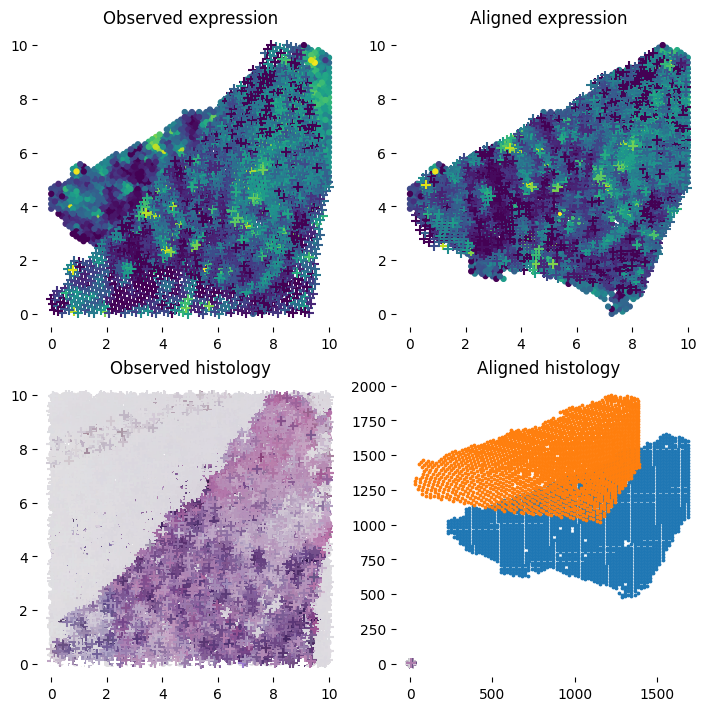

In [32]:
batch_aligment(level)

In [92]:
ad_pertub_name_list = pd.read_csv(simu_dataset_dir+level+'_noisy_simulation_data_names.csv', header=None)
ad_pertub_name_list.iloc[0,0]

'/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/data31_spatial_fresh_frozen_35sample_V19T26-028_C1/adata_layer_1_nb0.37_ang26.83_cut0.18.h5ad'

In [ ]:
all_distance = []
for src_sample_name in ad_pertub_name_list[0][1:]:
    distance = gpsa_aligment(data_slice1, src_sample_name)
    all_distance.append(distance)

/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2236550/1170187705.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2236550/1170187705.py:61: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  dat

Iter: 0          LL -4.721e+07
Iter: 100        LL -9.066e+05
Iter: 200        LL -2.993e+05
Iter: 300        LL -1.944e+05
Iter: 400        LL -1.586e+05
Iter: 500        LL -1.412e+05
Iter: 600        LL -1.299e+05
Iter: 700        LL -1.219e+05
Iter: 800        LL -1.160e+05
Iter: 900        LL -1.116e+05
Iter: 1000       LL -1.077e+05
Iter: 1100       LL -1.050e+05
Iter: 1200       LL -1.025e+05
Iter: 1300       LL -1.004e+05
Iter: 1400       LL -9.880e+04
Iter: 1500       LL -9.736e+04
Iter: 1600       LL -9.625e+04
Iter: 1700       LL -9.531e+04
Iter: 1800       LL -9.445e+04
Iter: 1900       LL -9.382e+04


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2236550/1170187705.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2236550/1170187705.py:61: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  dat

Iter: 0          LL -3.936e+07
Iter: 100        LL -3.245e+05
Iter: 200        LL -1.609e+05
Iter: 300        LL -1.222e+05
Iter: 400        LL -1.074e+05
Iter: 500        LL -1.012e+05
Iter: 600        LL -9.788e+04
Iter: 700        LL -9.577e+04
Iter: 800        LL -9.441e+04
Iter: 900        LL -9.351e+04
Iter: 1000       LL -9.277e+04
Iter: 1100       LL -9.236e+04
Iter: 1200       LL -9.191e+04
Iter: 1300       LL -9.159e+04
Iter: 1400       LL -9.121e+04
Iter: 1500       LL -9.082e+04
Iter: 1600       LL -9.051e+04
Iter: 1700       LL -9.028e+04
Iter: 1800       LL -8.994e+04
Iter: 1900       LL -8.975e+04


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2236550/1170187705.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2236550/1170187705.py:61: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  dat

Iter: 0          LL -7.319e+07
Iter: 100        LL -9.159e+05
Iter: 200        LL -4.769e+05
Iter: 300        LL -3.295e+05
Iter: 400        LL -2.576e+05
Iter: 500        LL -2.156e+05
Iter: 600        LL -1.894e+05
Iter: 700        LL -1.709e+05
Iter: 800        LL -1.571e+05
Iter: 900        LL -1.465e+05
Iter: 1000       LL -1.375e+05
Iter: 1100       LL -1.300e+05
Iter: 1200       LL -1.238e+05
Iter: 1300       LL -1.183e+05
Iter: 1400       LL -1.140e+05
Iter: 1500       LL -1.103e+05
Iter: 1600       LL -1.070e+05
Iter: 1700       LL -1.047e+05
Iter: 1800       LL -1.029e+05
Iter: 1900       LL -1.014e+05


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2236550/1170187705.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2236550/1170187705.py:61: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  dat

Iter: 0          LL -3.663e+08
Iter: 100        LL -4.294e+06


KeyboardInterrupt: 

In [ ]:
all_distance

/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_2236550/4207273045.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_2236550/4207273045.py:61: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  dat

Iter: 0          LL -1.382e+08
Iter: 100        LL -4.796e+05
Iter: 200        LL -3.147e+05
Iter: 300        LL -2.596e+05
Iter: 400        LL -2.321e+05
Iter: 500        LL -2.163e+05
Iter: 600        LL -2.054e+05
Iter: 700        LL -1.978e+05
Iter: 800        LL -1.914e+05
Iter: 900        LL -1.866e+05
Iter: 1000       LL -1.823e+05
Iter: 1100       LL -1.784e+05
Iter: 1200       LL -1.744e+05
Iter: 1300       LL -1.713e+05
Iter: 1400       LL -1.677e+05
Iter: 1500       LL -1.645e+05
Iter: 1600       LL -1.611e+05
Iter: 1700       LL -1.580e+05
Iter: 1800       LL -1.546e+05
Iter: 1900       LL -1.512e+05
CPU times: user 7h 10min 19s, sys: 8min 50s, total: 7h 19min 10s
Wall time: 14min 37s


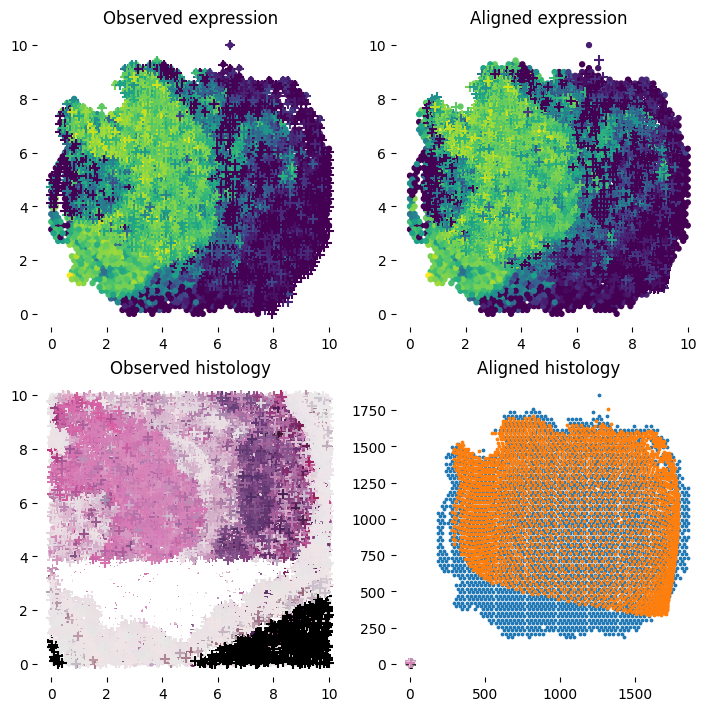

In [82]:
%%time
distance = gpsa_aligment(data_slice1, src_sample_name)

In [83]:
distance

79.105515

# Case Study

In [10]:
data_dir = '/condo/wanglab/shared/wxc/clip/data/human/ST_data/data12_Ovarian_Carcinosarcoma_4sample/'

In [11]:
DATA_DIR = data_dir
SCALEFACTOR = 0.17211704
GRAY_PIXEL_VAL = 0.7
N_GENES = 10

N_SAMPLES = 8000

n_spatial_dims = 2
n_views = 2

m_G = 200
m_X_per_view = 200

N_EPOCHS = 6000
# N_EPOCHS = 2000
PRINT_EVERY = 100
N_LATENT_GPS = {"expression": None, "histology": None}

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [ ]:
tar_sample_name = '10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data.h5ad'
data_slice1 = sc.read_h5ad(pjoin(DATA_DIR, tar_sample_name))
# data_slice1.uns['spatial'][library_id]['images']['hires'] = data_slice1.uns['spatial'][library_id]['images']['hires']/255
data_slice1 = process_data(data_slice1, n_top_genes=6000)
data_slice1 = process_image(data_slice1)

src_sample_name = '10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data.h5ad'
data_slice2 = sc.read_h5ad(pjoin(DATA_DIR, src_sample_name))
data_slice2 = process_data(data_slice2, n_top_genes=6000)
data_slice2 = process_image(data_slice2)

data = data_slice1.concatenate(data_slice2)

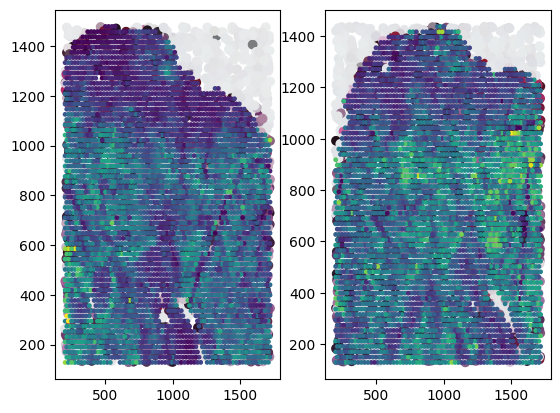

In [15]:
plt.subplot(121)
rand_idx = np.random.choice(np.arange(data_slice1.uns["img_spatial"].shape[0]), size=3000, replace=False)
plt.scatter(
    data_slice1.uns["img_spatial"][rand_idx][:, 0],
    data_slice1.uns["img_spatial"][rand_idx][:, 1],
    c=data_slice1.uns["img_pixels"][rand_idx],
)
plt.scatter(
    data_slice1.obsm["spatial"][:, 0],
    data_slice1.obsm["spatial"][:, 1],
    s=6,
    c=data_slice1.obs.total_counts.values,
)

plt.subplot(122)
rand_idx = np.random.choice(np.arange(data_slice2.uns["img_spatial"].shape[0]), size=3000, replace=False)
plt.scatter(
    data_slice2.uns["img_spatial"][rand_idx][:, 0],
    data_slice2.uns["img_spatial"][rand_idx][:, 1],
    c=data_slice2.uns["img_pixels"][rand_idx],
)
plt.scatter(
    data_slice2.obsm["spatial"][:, 0],
    data_slice2.obsm["spatial"][:, 1],
    s=6,
    c=data_slice2.obs.total_counts.values,
)
plt.show()

/tmp/ipykernel_1480357/2672798095.py:53: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  data = data_slice1.concatenate(data_slice2)
/tmp/ipykernel_1480357/168886673.py:252: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1692.)
  self.curr_Omega_tril_list = torch.cholesky(curr_Omega_G)


Iter: 0          LL -4.302e+07
Iter: 100        LL -4.787e+05
Iter: 200        LL -2.490e+05
Iter: 300        LL -1.683e+05
Iter: 400        LL -1.302e+05
Iter: 500        LL -1.093e+05
Iter: 600        LL -9.643e+04
Iter: 700        LL -8.849e+04
Iter: 800        LL -8.322e+04
Iter: 900        LL -7.974e+04
Iter: 1000       LL -7.716e+04
Iter: 1100       LL -7.564e+04
Iter: 1200       LL -7.433e+04
Iter: 1300       LL -7.356e+04
Iter: 1400       LL -7.303e+04
Iter: 1500       LL -7.248e+04
Iter: 1600       LL -7.219e+04
Iter: 1700       LL -7.198e+04
Iter: 1800       LL -7.179e+04
Iter: 1900       LL -7.158e+04
Iter: 2000       LL -7.152e+04
Iter: 2100       LL -7.147e+04
Iter: 2200       LL -7.132e+04
Iter: 2300       LL -7.136e+04
Iter: 2400       LL -7.133e+04
Iter: 2500       LL -7.123e+04
Iter: 2600       LL -7.123e+04
Iter: 2700       LL -7.108e+04
Iter: 2800       LL -7.104e+04
Iter: 2900       LL -7.105e+04
Iter: 3000       LL -7.134e+04
Iter: 3100       LL -7.131e+04
Iter: 32

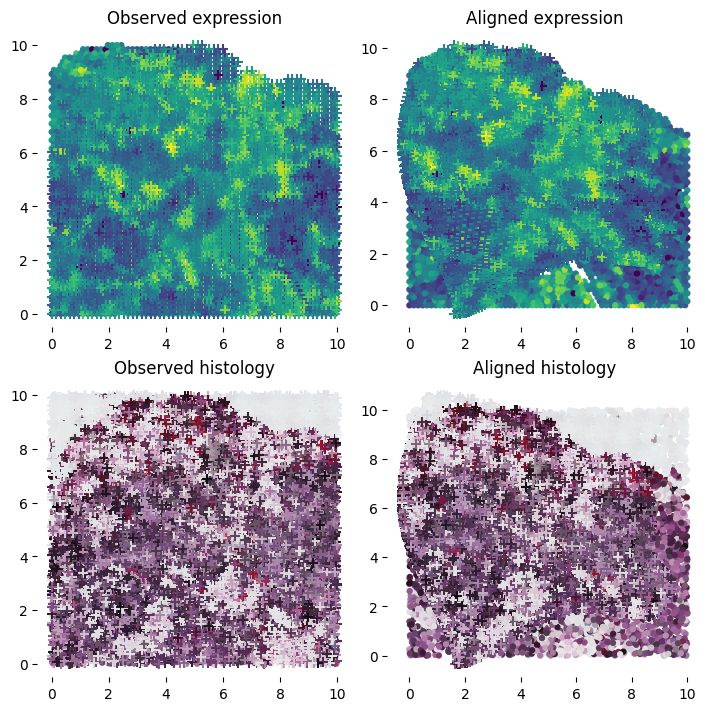

In [16]:
## Filter for spatially variable genes
shared_gene_names = data.var.gene_ids.index.values
data_knn = data_slice1[:, shared_gene_names]
X_knn = data_knn.obsm["spatial"]
Y_knn = np.array(data_knn.X.todense())
nbrs = NearestNeighbors(n_neighbors=2).fit(X_knn)
distances, indices = nbrs.kneighbors(X_knn)

preds = Y_knn[indices[:, 1]]
r2_vals = r2_score(Y_knn, preds, multioutput="raw_values")

gene_idx_to_keep = np.where(r2_vals > 0.3)[0]
N_GENES_new = min(N_GENES, len(gene_idx_to_keep))
gene_names_to_keep = data_knn.var.gene_ids.index.values[gene_idx_to_keep]
gene_names_to_keep = gene_names_to_keep[np.argsort(-r2_vals[gene_idx_to_keep])]
if N_GENES_new < len(gene_names_to_keep):
    gene_names_to_keep = gene_names_to_keep[:N_GENES_new]
data = data[:, gene_names_to_keep]

## Filter number of samples
if N_SAMPLES is not None:

    if N_SAMPLES < data_slice1.shape[0]:
        rand_idx = np.random.choice(
            np.arange(data_slice1.shape[0]), size=N_SAMPLES, replace=False
        )
        data_slice1 = data_slice1[rand_idx]

    if N_SAMPLES < data_slice1.uns["img_spatial"].shape[0]:
        rand_idx = np.random.choice(
            np.arange(data_slice1.uns["img_spatial"].shape[0]),
            size=N_SAMPLES,
            replace=False,
        )
        data_slice1.uns["img_spatial"] = data_slice1.uns["img_spatial"][rand_idx]
        data_slice1.uns["img_pixels"] = data_slice1.uns["img_pixels"][rand_idx]

    if N_SAMPLES < data_slice2.shape[0]:
        rand_idx = np.random.choice(
            np.arange(data_slice2.shape[0]), size=N_SAMPLES, replace=False
        )
        data_slice2 = data_slice2[rand_idx]

    if N_SAMPLES < data_slice2.uns["img_spatial"].shape[0]:
        rand_idx = np.random.choice(
            np.arange(data_slice2.uns["img_spatial"].shape[0]),
            size=N_SAMPLES,
            replace=False,
        )
        data_slice2.uns["img_spatial"] = data_slice2.uns["img_spatial"][rand_idx]
        data_slice2.uns["img_pixels"] = data_slice2.uns["img_pixels"][rand_idx]

data = data_slice1.concatenate(data_slice2)
data = data[:, gene_names_to_keep]
n_samples_list_expression = [data_slice1.shape[0], data_slice2.shape[0]]
n_samples_list_histology = [
    data_slice1.uns["img_spatial"].shape[0],
    data_slice2.uns["img_spatial"].shape[0],
]
view_idx = [
    np.arange(data_slice1.shape[0]),
    np.arange(data_slice1.shape[0], data_slice1.shape[0] + data_slice2.shape[0]),
]

### Expression
X1_expression = data[data.obs.batch == "0"].obsm["spatial"]
X2_expression = data[data.obs.batch == "1"].obsm["spatial"]
Y1_expression = np.array(data[data.obs.batch == "0"].X.todense())
Y2_expression = np.array(data[data.obs.batch == "1"].X.todense())

X1_expression = scale_spatial_coords(X1_expression)
X2_expression = scale_spatial_coords(X2_expression)

Y1_expression = (Y1_expression - Y1_expression.mean(0)) / Y1_expression.std(0)
Y2_expression = (Y2_expression - Y2_expression.mean(0)) / Y2_expression.std(0)

X_expression = np.concatenate([X1_expression, X2_expression])
Y_expression = np.concatenate([Y1_expression, Y2_expression])

### Histology
X1_histology = data_slice1.uns["img_spatial"]
X2_histology = data_slice2.uns["img_spatial"]
Y1_histology = data_slice1.uns["img_pixels"]
Y2_histology = data_slice2.uns["img_pixels"]

X1_histology = scale_spatial_coords(X1_histology)
X2_histology = scale_spatial_coords(X2_histology)

Y1_histology_rgb = Y1_histology.copy()
Y2_histology_rgb = Y2_histology.copy()


Y1_histology_mean = Y1_histology.mean(0)
Y1_histology_stddev = Y1_histology.std(0)
Y2_histology_mean = Y2_histology.mean(0)
Y2_histology_stddev = Y2_histology.std(0)

Y1_histology = (Y1_histology - Y1_histology_mean) / Y1_histology_stddev
Y2_histology = (Y2_histology - Y2_histology_mean) / Y2_histology_stddev

X_histology = np.concatenate([X1_histology, X2_histology])
Y_histology = np.concatenate([Y1_histology, Y2_histology])
Y_histology_rgb = np.concatenate([Y1_histology_rgb, Y2_histology_rgb])

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

x_expression = torch.from_numpy(X_expression).float().clone()
x_histology = torch.from_numpy(X_histology).float().clone()
y_expression = torch.from_numpy(Y_expression).float().clone()
y_histology = torch.from_numpy(Y_histology).float().clone()
y_histology_rgb = torch.from_numpy(Y_histology_rgb).float().clone()

data_dict = {
    "expression": {
        "spatial_coords": x_expression,
        "outputs": y_expression,
        "n_samples_list": n_samples_list_expression,
    },
    "histology": {
        "spatial_coords": x_histology,
        "outputs": y_histology,
        "n_samples_list": n_samples_list_histology,
    },
}


data_dict_rgb = {
    "expression": {
        "spatial_coords": x_expression,
        "outputs": y_expression,
        "n_samples_list": n_samples_list_expression,
    },
    "histology": {
        "spatial_coords": x_histology,
        "outputs": y_histology_rgb,
        "n_samples_list": n_samples_list_histology,
    },
}

model = VariationalGPSA(
    data_dict,
    n_spatial_dims=n_spatial_dims,
    m_X_per_view=m_X_per_view,
    m_G=m_G,
    data_init=True,
    minmax_init=False,
    grid_init=False,
    n_latent_gps=N_LATENT_GPS,
    mean_function="identity_fixed",
    # fixed_warp_kernel_variances=np.ones(n_views) * 0.1,
    # fixed_warp_kernel_lengthscales=np.ones(n_views) * 10,
    n_noise_variance_params=3,
    fixed_view_idx=0,
).to(device)

view_idx, Ns, _, _ = model.create_view_idx_dict(data_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

def train(model, loss_fn, optimizer):
    model.train()

    # Forward pass
    G_means, G_samples, F_latent_samples, F_samples = model.forward(
        X_spatial={"expression": x_expression, "histology": x_histology},
        view_idx=view_idx,
        Ns=Ns,
    )

    # Compute loss
    loss = loss_fn(data_dict, F_samples)

    # Compute gradients and take optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), G_means


# Set up figure.
fig = plt.figure(figsize=(7, 7), facecolor="white", constrained_layout=True)

data_expression_ax = fig.add_subplot(221, frameon=False)
data_histology_ax = fig.add_subplot(222, frameon=False)
latent_expression_ax = fig.add_subplot(223, frameon=False)
latent_histology_ax = fig.add_subplot(224, frameon=False)
axes_list = [
    data_expression_ax,
    data_histology_ax,
    latent_expression_ax,
    latent_histology_ax,
]

for t in range(N_EPOCHS):
    loss, G_means = train(model, model.loss_fn, optimizer)

    if t % PRINT_EVERY == 0:
        print("Iter: {0:<10} LL {1:1.3e}".format(t, -loss), flush=True)

        callback_twod_multimodal(
            model=model,
            data_dict=data_dict_rgb,
            axes=axes_list,
            X_aligned=G_means,
            scatterpoint_size=50,
            rgb=True,
        )

        curr_aligned_coords_expression = G_means["expression"].detach().numpy()
        curr_aligned_coords_histology = G_means["histology"].detach().numpy()

In [17]:
# rand0-3rd 10

In [18]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

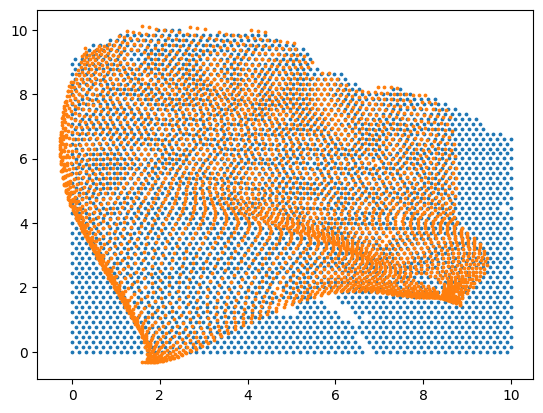

In [19]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [20]:
# rand0-3rd 10

In [26]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

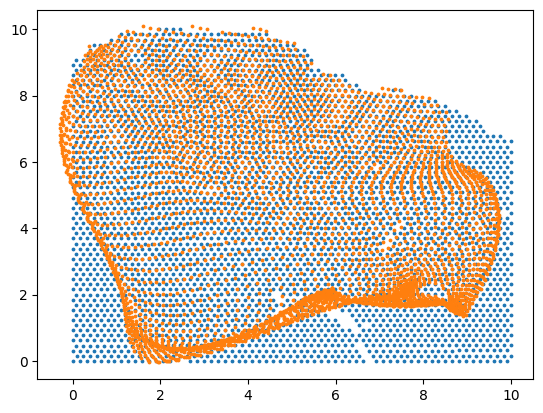

In [27]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [ ]:
# 100

In [23]:
# rand0-3rd

In [24]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

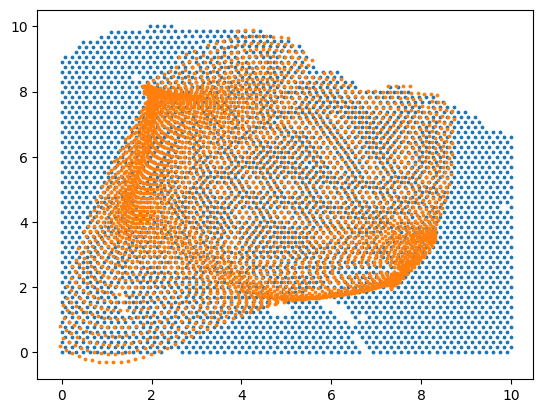

In [40]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [16]:
# rand0-3rd

In [17]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

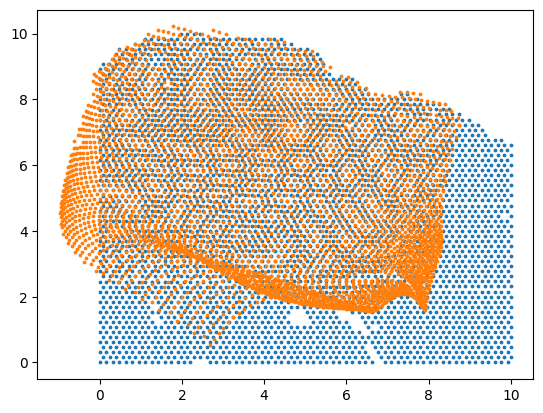

In [18]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [78]:
# rand0-2nd

In [79]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

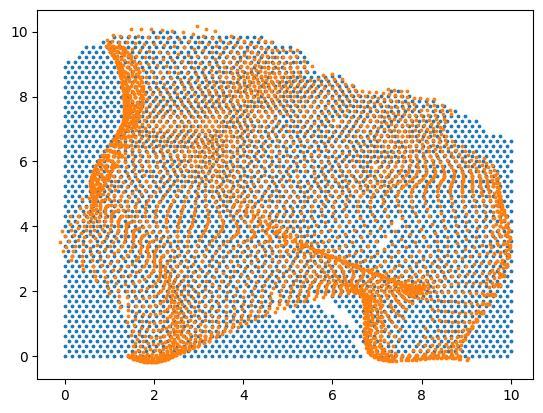

In [80]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [69]:
# rand0

In [70]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

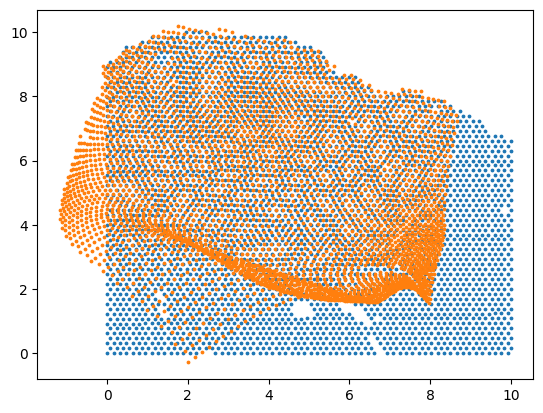

In [71]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [16]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]

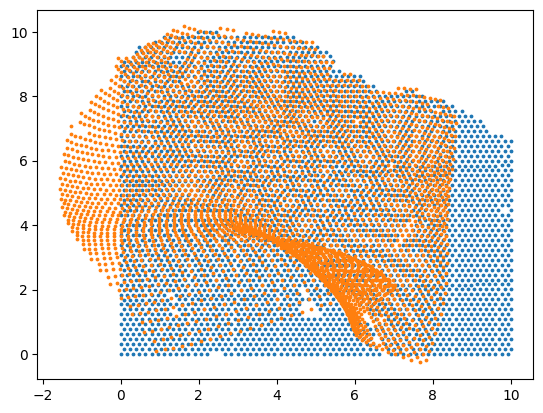

In [17]:
plt.scatter(ad_tar_coor_curr[:,0], ad_tar_coor_curr[:,1],s=3)
plt.scatter(ad_src_coor_curr[:,0], ad_src_coor_curr[:,1],s=3)

In [28]:
pd.DataFrame(ad_tar_coor_curr).to_csv('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_tar_coor.csv')
pd.DataFrame(ad_src_coor_curr).to_csv('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_align_coor.csv')

In [29]:
data_slice1.write_h5ad('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_target.h5ad')
data_slice2.write_h5ad('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_alignment.h5ad')

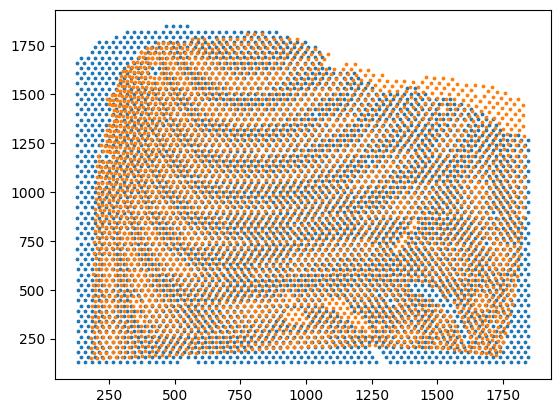

In [26]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]
ad_tar_coor = (ad_tar_coor_curr/10)*data_slice1.obsm['spatial'].max()+data_slice1.obsm['spatial'].min()
ad_src_coor = (ad_src_coor_curr/10)*data_slice2.obsm['spatial'].max()+data_slice2.obsm['spatial'].min()

plt.scatter(ad_tar_coor[:,0], ad_tar_coor[:,1],s=3)
plt.scatter(ad_src_coor[:,0], ad_src_coor[:,1],s=3)

In [1]:
plt.scatter(ad_tar_coor[:,0], ad_tar_coor[:,1],s=3)
plt.scatter(ad_src_coor[:,0], ad_src_coor[:,1],s=3)

NameError: name 'plt' is not defined

In [27]:
pd.DataFrame(ad_src_coor).to_csv('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_alignment.csv')

In [28]:
data_slice2.write_h5ad('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_alignment.h5ad')

In [16]:
curr_aligned_coords_expression

array([[1.2627015e+00, 6.0867978e-04],
       [8.0289936e+00, 7.6952338e+00],
       [3.3878877e+00, 4.6290097e-01],
       ...,
       [1.3148974e+00, 9.8146238e+00],
       [7.6916730e-01, 7.9209743e+00],
       [3.4673991e+00, 6.8782508e-01]], dtype=float32)

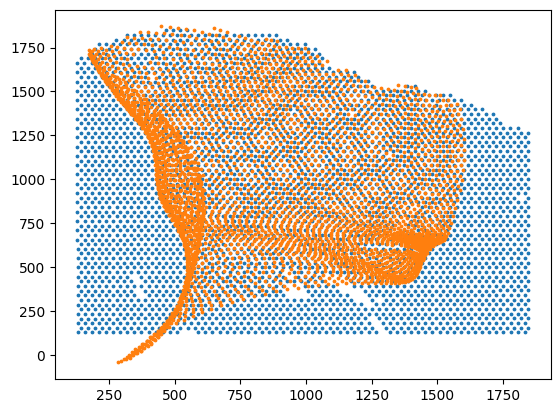

In [84]:
ad_tar_coor_curr = curr_aligned_coords_expression[:data_slice1.shape[0]]
ad_src_coor_curr = curr_aligned_coords_expression[data_slice1.shape[0]:]
ad_tar_coor = (ad_tar_coor_curr/10)*data_slice1.obsm['spatial'].max()+data_slice1.obsm['spatial'].min()
ad_src_coor = (ad_src_coor_curr/10)*data_slice2.obsm['spatial'].max()+data_slice2.obsm['spatial'].min()

plt.scatter(ad_tar_coor[:,0], ad_tar_coor[:,1],s=3)
plt.scatter(ad_src_coor[:,0], ad_src_coor[:,1],s=3)

In [17]:
ad_src_coor.to_csv('/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/gpsa/gpsa_alignment.csv')

NameError: name 'ad_src_coor' is not defined